In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
from neurostim.analysis import quick_sim_setup
import numpy as np
import pandas as pd
from neuron import h
from article_figures.article_plot_functions import plot_morphology_with_light, spatial_activation_plot, map_patt_id_2_xy, label_subplots_ABC
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.cm import jet
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import pickle
from copy import copy
mpl.rc("font", size=8, family='Arial')
#plt.rcParams['font.family'] = 'Arial'

def plot_spikes(ax, spike_times, height=1.0, color='black', linewidth=1):
    # Plot vertical lines for spikes
    for t in spike_times:
        ax.vlines(t, 0.1, height, color=color, linewidth=linewidth)
    
    # Formatting the axis
    ax.set_ylim(0, height)
    ax.set_yticks([])
    
    # Remove all spines except the bottom
    for spine in ['top', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    
    # Remove y-axis and x-axis ticks
    ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    
    ax.set_xlabel('200 ms')

    # Optional: set tighter limits
    ax.set_xlim(0, 200)
    ax.set_ylim(0,1)

def connect_inset(ax_main, ax_inset, xlim, ylim, color='black', linewidth=0.8):
    """
    Draw two connecting lines between the zoom rectangle in ax_main and the inset ax_inset.

    Parameters:
    - ax_main: The main Axes with the rectangle.
    - ax_inset: The inset Axes.
    - xlim, ylim: Tuples defining the rectangle in data coords.
    """
    fig = ax_main.figure

    # Define corners of the zoom area in data coordinates
    rect_ll = (xlim[0], ylim[0])  # lower left
    rect_ur = (xlim[1], ylim[1])  # upper right

    # Transform those to display coordinates
    trans_main = ax_main.transData
    rect_ll_disp = trans_main.transform(rect_ll)
    rect_ur_disp = trans_main.transform(rect_ur)

    # Use ax_inset.bbox to get its lower left and upper left in display coords
    bbox = ax_inset.bbox
    inset_ll_disp = (bbox.x0, bbox.y0)
    inset_ur_disp = (bbox.x1, bbox.y1)

    # Convert display coordinates to figure coordinates
    to_fig = fig.transFigure.inverted()
    p1 = to_fig.transform(rect_ll_disp)
    p2 = to_fig.transform(rect_ur_disp)
    q1 = to_fig.transform(inset_ll_disp)
    q2 = to_fig.transform(inset_ur_disp)

    # Create and add connector lines
    for (start, end) in [(p1, q1), (p2, q2)]:
        line = Line2D(
            [start[0], end[0]], [start[1], end[1]],
            transform=fig.transFigure, color=color, linewidth=linewidth
        )
        fig.lines.append(line)

def add_inset(main_ax, inset_ax, xlim, ylim):
    inset_ax.set_xlim(*xlim)
    inset_ax.set_ylim(*ylim)
    rect = patches.Rectangle((xlim[0], ylim[0]), xlim[1] - xlim[0], ylim[1] - ylim[0],
                             linewidth=1, edgecolor='black', facecolor='none', linestyle='solid')
    main_ax.add_patch(rect)
    connect_inset(ax_main=main_ax, ax_inset=inset_ax, xlim=xlim, ylim=ylim, color='black', linewidth=0.8)
    frame = patches.Rectangle(
        (0, 0), 1, 1,               # full extent of ax
        transform=inset_ax.transAxes,
        linewidth=1.5,
        edgecolor='black',
        facecolor='none',
        zorder=10  # ensure it's above plot elements if needed
    )
    #inset_ax.add_patch(frame)

def cell_plot(main_ax, main_args, inset_args, inset_xlim, inset_ylim):
    simcontrol.cell.sim_tree.plot2DMorphology(ax=main_ax, **main_args)
    xlims = main_ax.get_xlim()
    main_ax.set_xlim(xlims[0]+150, xlims[1]+150)
    #inset_xlim = (inset_xlim[0]+150, inset_xlim[1]+150)
    inset_ax = fig.add_axes([main_ax.get_position().x1 - main_ax.get_position().width *0.3, 
                             main_ax.get_position().y1 - main_ax.get_position().height*0.2,
                             main_ax.get_position().width *0.2, 
                             main_ax.get_position().height*0.2*0.67])
    simcontrol.cell.sim_tree.plot2DMorphology(ax=inset_ax, **inset_args)
    add_inset(main_ax, inset_ax, xlim=inset_xlim, ylim=inset_ylim)
    return main_ax, inset_ax

--No graphics will be displayed.


In [2]:
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_1",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=50,
        NA=0.1),
)
n_secs_cell1 = len([seg for sec in simcontrol.cell.sections for seg in sec])
node_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_node_data.npy'
# Calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000 # data points
xs = np.linspace(-300,300, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])
I = I/np.max(I)




              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

In [3]:
# create colormapping based on grouping
with open('snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-grouping.pickle', 'rb') as f:
    grouping = pickle.load(f)
colorfloats = np.arange(len(grouping.keys())) / len(grouping.keys())
np.random.shuffle(colorfloats)
sec_colors = dict()
node_marklocs = []
node_locargs = []
comp_marklocs = []
comp_locargs = []
comp_locargs_gray = []
for i, (key, vals) in enumerate(grouping.items()):
    sec_colors[int(key)] = colorfloats[i]
    node_marklocs.append({'node': int(key), 'x': 0.50 })
    node_locargs.append(dict(marker='.', mec=jet(colorfloats[i]), mfc=jet(colorfloats[i]), markersize=6))
    comp_marklocs.append({'node': int(key), 'x': 0.50 })
    comp_locargs.append(dict(marker='.', mec=jet(colorfloats[i]), mfc=jet(colorfloats[i]), markersize=8))
    comp_locargs_gray.append(dict(marker='.', mec='gray', mfc='gray', markersize=5))
    for val in vals:
        sec_colors[int(val)] = colorfloats[i]
        comp_marklocs.append({'node': int(val), 'x': 0.50 })
        comp_locargs.append(dict(marker='.', mec=jet(colorfloats[i]), mfc=jet(colorfloats[i]), markersize=5))
        comp_locargs_gray.append(dict(marker='.', mec='gray', mfc='gray', markersize=5))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

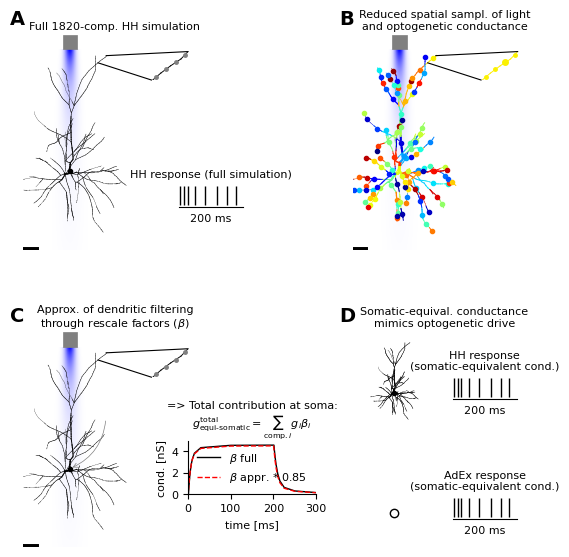

In [4]:
# figure format
a4_w = 8.27
a4_l = 11.7

fig = plt.figure(figsize=(a4_w*0.8, a4_w*0.8))
outer = gridspec.GridSpec(2, 2, figure=fig, wspace=0.8, hspace=0.4)
ax0 = fig.add_subplot(outer[0, 0]) # Top-left
ax1 = fig.add_subplot(outer[0, 1]) # Top-right
ax2 = fig.add_subplot(outer[1, 0]) # Bottom-left
# Bottom-right
inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[1, 1], hspace=0.3)
ax3 = fig.add_subplot(inner[0, 0])  # Top-left sub-tile
ax3.axis('off')
ax4 = fig.add_subplot(inner[1, 0])  # Bottom-left sub-tile
ax4.axis('off')
ax5 = fig.add_subplot(inner[0, 1])  # Top-right sub-tile
ax6 = fig.add_subplot(inner[1, 1])  # Bottom-right sub-tile

# cell plot inset limits
in_xlim = (98,126)
in_ylim = (377,402)
# full model
ax0, inset_ax0 = cell_plot(
    main_ax=ax0,
    main_args=dict(cs=None,cmap=jet,plotargs=dict(lw=1,c='k'),marklocs=[{'node': 1, 'x': 0.50 }],locargs=[dict(marker='.', mec='black', mfc='black')]),
    inset_args=dict(cs=None,cmap=jet,plotargs=dict(lw=2),marklocs=comp_marklocs,locargs=comp_locargs_gray),
    inset_xlim=in_xlim,
    inset_ylim=in_ylim
)
# plot light profile
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', ['white', 'blue'], N=256)
mappable = ax0.pcolormesh(xx,zz+soma_depth,I, cmap=custom_cmap)
# add fiber illustration:
rect = patches.Rectangle((-25, soma_depth), 50, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=ax0.transData)
fig.add_artist(rect)
# spike display
raster_ax0 = fig.add_axes([ax0.get_position().x1 - ax0.get_position().width*0.15, 
              ax0.get_position().y0 + ax0.get_position().height*0.2,
              ax0.get_position().width*0.35, 
              ax0.get_position().height*0.1])
plot_spikes(ax=raster_ax0, spike_times=[5,16,27,50,81,118,150,177], height=1.0, color='black', linewidth=1)
#
#
#
# reduced model illustration
ax1, inset_ax1 = cell_plot(
    main_ax=ax1,
    main_args=dict(cs=sec_colors,cmap=jet,plotargs=dict(lw=2),marklocs=node_marklocs,locargs=node_locargs),
    inset_args=dict(cs=sec_colors, cmap=jet, plotargs=dict(lw=2), marklocs=comp_marklocs, locargs=comp_locargs),
    inset_xlim=in_xlim,
    inset_ylim=in_ylim
)
# plot light profile
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', ['white', 'blue'], N=256)
mappable = ax1.pcolormesh(xx,zz+soma_depth,I, cmap=custom_cmap)
# add fiber illustration:
rect = patches.Rectangle((-25, soma_depth), 50, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=ax1.transData)
fig.add_artist(rect)
#
#
#
# approximation of dendritic filtering
ax2, inset_ax2 = cell_plot(
    main_ax=ax2,
    main_args=dict(cs=None,cmap=jet,plotargs=dict(lw=1,c='k'),marklocs=[{'node': 1, 'x': 0.50 }],locargs=[dict(marker='.', mec='black', mfc='black')]),
    inset_args=dict(cs=None,cmap=jet,plotargs=dict(lw=2),marklocs=comp_marklocs,locargs=comp_locargs_gray),
    inset_xlim=in_xlim,
    inset_ylim=in_ylim
)
# plot light profile
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', ['white', 'blue'], N=256)
mappable = ax2.pcolormesh(xx,zz+soma_depth,I, cmap=custom_cmap)
# add fiber illustration:
rect = patches.Rectangle((-25, soma_depth), 50, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=ax2.transData)
fig.add_artist(rect)
# add arrow
start = (125,175)
end = (0, 0)
ax2.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", linewidth=0.5, color='gray', connectionstyle="arc3,rad=-0.3"))
eq1 = "Rescale by "+r"$\beta$"
#ax2.text(335, 365, eq1, fontsize=8, ha='left', va='center')
eq2_1 = "=> Total contribution at soma:\n"
eq2_2 = r"$g^{\mathrm{total}}_{\mathrm{equi\text{-}somatic}} = \sum_{\mathrm{comp.} i} g_i \beta_i$"

condprofs_ax2 = fig.add_axes([ax2.get_position().x1 - ax2.get_position().width*0.1, 
                              ax2.get_position().y0 + ax2.get_position().height*0.25,
                              ax2.get_position().width*0.7, 
                              ax2.get_position().height*0.25])
#inset_ax2.text(in_xlim[0]+1.*(in_xlim[1]-in_xlim[0]), in_ylim[0], eq1, fontsize=8,ha='left', va='center')
condprofs_ax2.set_title(eq2_1+eq2_2, fontsize=8)
smpled_times, smpled_RON_cond, smpled_full_cond = np.load('cond_w_wo_interactions.npy')
condprofs_ax2.plot(smpled_times, smpled_full_cond, label=r'$\beta$ full', c='black', ls='solid',lw=1)
condprofs_ax2.plot(smpled_times, smpled_RON_cond*0.85, label=r'$\beta$ appr. * 0.85', c='red', ls='dashed',lw=1)
condprofs_ax2.set_xlabel('time [ms]')
condprofs_ax2.set_ylabel('cond. [nS]')
condprofs_ax2.set_yticks([0,2,4,6])
condprofs_ax2.set_ylim(0,5)
condprofs_ax2.set_xlim(0,300)
#condprofs_ax2.set_ylim(0,1.7)
[condprofs_ax2.spines[spine].set_visible(False) for spine in ['top', 'right']] 
condprofs_ax2.legend(frameon=False)
#
#
#
# response comparison of injected HH model and injected adex
ax3 = fig.add_axes([ax3.get_position().x0 + ax3.get_position().width*0., 
                    ax3.get_position().y0 + ax3.get_position().height*0,
                    ax3.get_position().width, 
                    ax3.get_position().height])
ax4 = fig.add_axes([ax4.get_position().x0 + ax4.get_position().width*0., 
                    ax4.get_position().y0 + ax4.get_position().height*0,
                    ax4.get_position().width, 
                    ax4.get_position().height])
raster_ax5 = fig.add_axes([ax5.get_position().x0 + ax5.get_position().width*0., 
                           ax5.get_position().y0 + ax5.get_position().height*0.3,
                           ax0.get_position().width*0.35, 
                           ax0.get_position().height*0.1])
raster_ax6 = fig.add_axes([ax6.get_position().x0 + ax6.get_position().width*0., 
                           ax6.get_position().y0 + ax6.get_position().height*0.3,
                           ax0.get_position().width*0.35, 
                           ax0.get_position().height*0.1])
HH_plot_args = dict(cs=None,cmap=jet,plotargs=dict(lw=1,c='k'),marklocs=[{'node': 1, 'x': 0.50 }],locargs=[dict(marker='.', mec='black', mfc='black')], sb_draw=False)
simcontrol.cell.sim_tree.plot2DMorphology(ax=ax3, **HH_plot_args)
AdEx_plot_args = dict(cs=None,cmap=jet,plotargs=dict(lw=0,c='k'),marklocs=[{'node': 1, 'x': 0.50 }],locargs=[dict(marker='o', mec='black', mfc='white')], sb_draw=False)
simcontrol.cell.sim_tree.plot2DMorphology(ax=ax4, **AdEx_plot_args)
# spike profiles of test conditions
plot_spikes(ax=raster_ax5, spike_times=[5,16,27,50,81,118,150,177], height=1.0, color='black', linewidth=1)
plot_spikes(ax=raster_ax6, spike_times=[5,16,27,50,81,118,150,177], height=1.0, color='black', linewidth=1)
for ax in [ax3, ax4,ax5, ax6]:
    ax.axis('off')
title0 = ax0.set_title('Full 1820-comp. HH simulation', fontsize=8)
title1 = ax1.set_title('Reduced spatial sampl. of light\nand optogenetic conductance', fontsize=8)
title2 = ax2.set_title('Approx. of dendritic filtering\nthrough '+r'rescale factors ($\beta$)', fontsize=8)
# position title3 centered to title1 and at the height as title2:
#title1_x = fig.transFigure.inverted().transform(ax1.transAxes.transform(title1.get_position()))[0]
#title2_y = fig.transFigure.inverted().transform(ax2.transAxes.transform(title2.get_position()))[1]
#fig.text(title1_x, title2_y, 'Capture entire optogenetic conductance in\nsingle somatic-equivalent conductance', fontsize=8, ha='center', va='bottom')
supplem_ax = fig.add_axes([ax1.get_position().x0, 
                           ax2.get_position().y0,
                           ax1.get_position().width, 
                           ax2.get_position().height])
supplem_ax.axis('off')
supplem_ax.set_title('Somatic-equival. conductance\nmimics optogenetic drive', fontsize=8)
raster_ax0.set_title('HH response (full simulation)', fontsize=8)
raster_ax5.set_title('HH response\n(somatic-equivalent cond.)', fontsize=8)
raster_ax6.set_title('AdEx response\n(somatic-equivalent cond.)', fontsize=8)

label_subplots_ABC(
        fig, 
        axs=[ax0, ax1, ax2, supplem_ax], 
        x_shift=-0.02, 
        y_shift=0.02, 
        fontsize=14, 
        weight='bold'
)

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fig.savefig('testfigure_reduction.png', dpi=300)

In [ ]:
fig, ax0 = plt.subplots(figsize=(4,4))
ax0, inset_ax0 = cell_plot(
    main_ax=ax0,
    main_args=dict(cs=sec_colors,cmap=jet,plotargs=dict(lw=2),marklocs=comp_marklocs,locargs=comp_locargs),
    inset_args=dict(cs=sec_colors, cmap=jet, plotargs=dict(lw=2), marklocs=comp_marklocs, locargs=comp_locargs),
    inset_xlim=(100,130),
    inset_ylim=(370,400)
)

In [ ]:
help(simcontrol.cell.sim_tree.plot2DMorphology)

In [ ]:
break



# full morphology

# reduced morphology


# add full neuron
simcontrol.cell.sim_tree.plot2DMorphology(
        ax=ax3,
        plotargs={'c': 'k', 'lw': 0.5, 'alpha':1},
        marklocs=[{'node': 1, 'x': 0.50 }], 
        locargs=[dict(marker='.', mec='black', mfc='black')],
        draw_soma_circle=False,
        sb_width=1,
        sb_draw=False
    )

# add adex neuron by drawing soma only
(
        ax=ax4,
        plotargs={'c': 'k', 'lw': 0.0, 'alpha':1},
        marklocs=[{'node': 1, 'x': 0.50 }], 
        locargs=[dict(marker='o', mec='black', mfc='none')],
        draw_soma_circle=False,
        sb_width=1,
        sb_draw=False
    )


In [ ]:
list(grouping.keys())[100]

In [ ]:
grouping